## Pharmacophore
Extracting and applying pharmacophore hypothesis<br><br>
here, we use rdkit; for more details see<br>
https://www.rdkit.org/docs/GettingStartedInPython.html

In [85]:
# importing 
import os
import requests
import xml.etree.ElementTree as ET
#from chembl_webresource_client.new_client import new_client
import pandas as pd
import math
from rdkit import Chem, RDConfig, Geometry
from rdkit.Chem import Draw, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, ChemicalFeatures
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
import rdkit.Chem.Pharm3D.Pharmacophore as Ph
from rdkit.ML.InfoTheory import InfoBitRanker
import numpy as np
from matplotlib import pyplot as plt

In [86]:
os.getcwd()

'/home/113600/structural_bioinformatics/Project3'

In [87]:
# read in the data from Exercise 2
# mol_data = pd.read_csv('ABL_comp_IC50.csv')
mol_data = pd.read_csv('data/EGFR_compounds.csv')

In [88]:
mol_data.head()

,Unnamed: 0,molecule_chembl_id,units,IC50,smiles,pIC50
0,0,CHEMBL2367667,nM,0.036,C=CC[C@H]1C(=O)N(S(=O)(=O)c2ccc3ccccc3c2)[C@H]...,10.443697
1,1,CHEMBL3617973,nM,0.065,CC1=C(C#N)[C@@H](c2ccc(C#N)cc2S(C)(=O)=O)N(C)C...,10.187087
2,2,CHEMBL293138,nM,0.100,CC(SC(=O)c1cccs1)C(=O)NCC(=O)N1CSCC1C(=O)O,10.000000
3,3,CHEMBL3617966,nM,0.210,CNC(=O)c1cc(-c2ccnn2-c2ccc(C#N)cc2)c(C)n(-c2cc...,9.677781
4,4,CHEMBL3912018,nM,0.300,CC(=O)C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N(C)C1c...,9.522879


,Unnamed: 0,molecule_chembl_id,units,IC50,smiles,pIC50,ROMol
0,0,CHEMBL2367667,nM,0.036,C=CC[C@H]1C(=O)N(S(=O)(=O)c2ccc3ccccc3c2)[C@H]...,10.443697,
1,1,CHEMBL3617973,nM,0.065,CC1=C(C#N)[C@@H](c2ccc(C#N)cc2S(C)(=O)=O)N(C)C...,10.187087,
2,2,CHEMBL293138,nM,0.100,CC(SC(=O)c1cccs1)C(=O)NCC(=O)N1CSCC1C(=O)O,10.000000,
3,3,CHEMBL3617966,nM,0.210,CNC(=O)c1cc(-c2ccnn2-c2ccc(C#N)cc2)c(C)n(-c2cc...,9.677781,
4,4,CHEMBL3912018,nM,0.300,CC(=O)C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N(C)C1c...,9.522879,

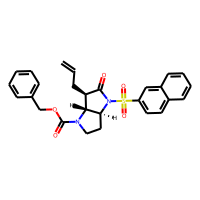
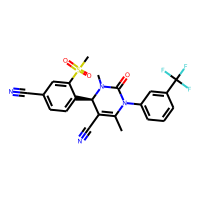
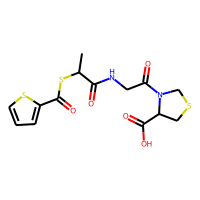
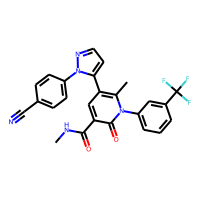
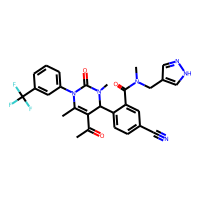

In [89]:
# add the chemical structures - same as in the Exercise 2
PandasTools.AddMoleculeColumnToFrame(mol_data, smilesCol='smiles')
mol_data.head()

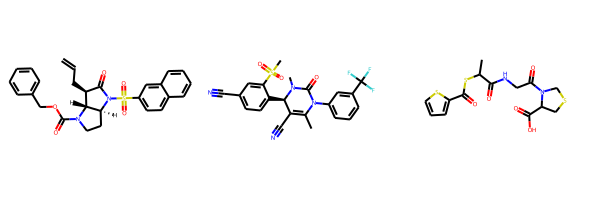

In [90]:
Draw.MolsToGridImage(mol_data.ROMol[:3])

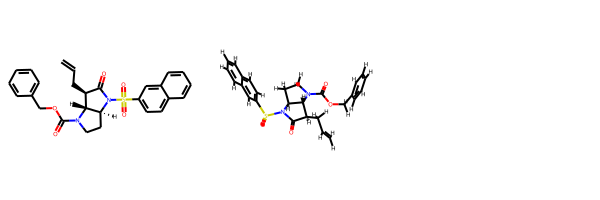

In [91]:
# make a 3D model structure of one of the molecules
m = mol_data.ROMol[0]
m_3D = Chem.AddHs(m)
AllChem.EmbedMolecule(m_3D)
AllChem.UFFOptimizeMolecule(m_3D)
Draw.MolsToGridImage([m,m_3D])

array([[<AxesSubplot:title={'center':'log_IC50'}>]], dtype=object)

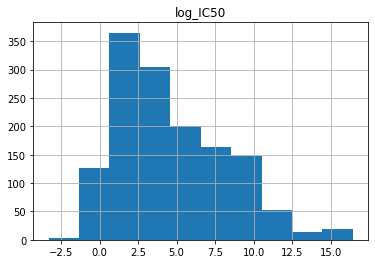

In [92]:
# as IC50 has a very large range of values, we look at log(IC50)
# note that the order stays the same
mol_data['log_IC50']=np.log(mol_data.IC50)
mol_data.hist(column = 'log_IC50') # plot histogram

(array([  4., 127., 365., 304., 196., 166., 151.,  52.,  14.,  18.]),
 array([-3.32423634, -1.34999268,  0.62425098,  2.59849463,  4.57273829,
         6.54698195,  8.52122561, 10.49546927, 12.46971293, 14.44395659,
        16.41820024]),
 <BarContainer object of 10 artists>)

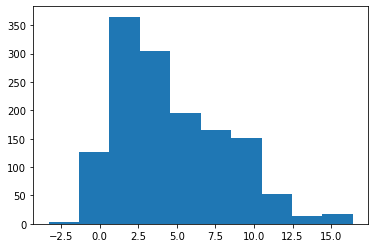

In [93]:
plt.hist(mol_data.log_IC50[:-1])#histogram excluding one outlier

,Unnamed: 0,molecule_chembl_id,units,IC50,smiles,pIC50,ROMol,log_IC50
0,0,CHEMBL2367667,nM,0.036,C=CC[C@H]1C(=O)N(S(=O)(=O)c2ccc3ccccc3c2)[C@H]...,10.443697,,-3.324236
1,1,CHEMBL3617973,nM,0.065,CC1=C(C#N)[C@@H](c2ccc(C#N)cc2S(C)(=O)=O)N(C)C...,10.187087,,-2.733368
2,2,CHEMBL293138,nM,0.100,CC(SC(=O)c1cccs1)C(=O)NCC(=O)N1CSCC1C(=O)O,10.000000,,-2.302585
3,3,CHEMBL3617966,nM,0.210,CNC(=O)c1cc(-c2ccnn2-c2ccc(C#N)cc2)c(C)n(-c2cc...,9.677781,,-1.560648
4,4,CHEMBL3912018,nM,0.300,CC(=O)C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N(C)C1c...,9.522879,,-1.203973
5,5,CHEMBL4110495,nM,0.300,[C-]#[N+]C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N[C@...,9.522879,,-1.203973
6,6,CHEMBL4107034,nM,0.450,[C-]#[N+]C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N(CC...,9.346787,,-0.798508
7,7,CHEMBL4107106,nM,0.500,[C-]#[N+]C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N[C@...,9.301030,,-0.693147
8,8,CHEMBL3617965,nM,0.500,Cc1c([S+]([O-])c2ccc(C#N)cc2)cc(C(=O)NCCCN2CCC...,9.301030,,-0.693147
9,9,CHEMBL2367646,nM,0.690,C=CC[C@H]1C(=O)N(C(C)=O)[C@H]2CCN(C(=O)OCc3ccc...,9.161151,,-0.371064

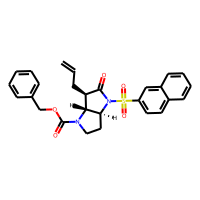
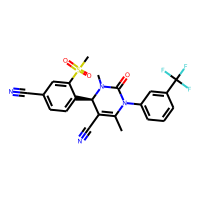
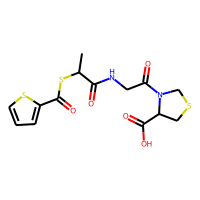
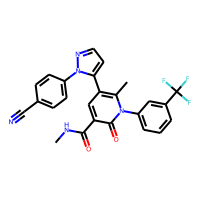
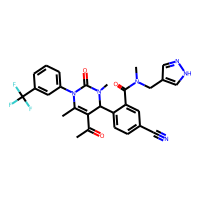
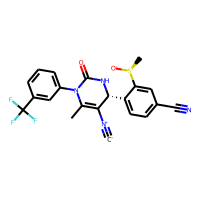
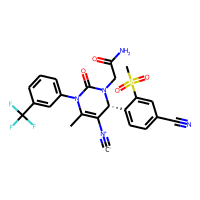
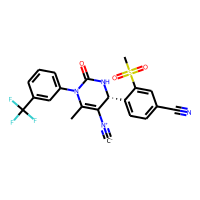
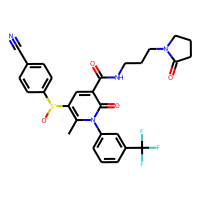
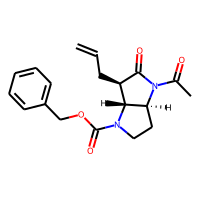
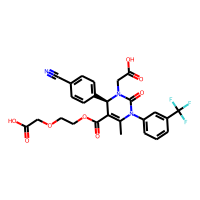
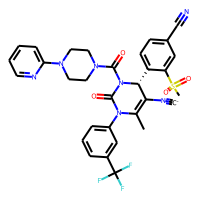

In [94]:
# filtering out only the most active compounds with IC50 < 1nM
mol_data[mol_data.IC50<1]

In [95]:
# calculating properties needed to apply Lipinski’s rule of 5
mol_list = mol_data.ROMol
MWs = [Descriptors.ExactMolWt(mol) for mol in mol_list]
HBAs = [Descriptors.NumHAcceptors(mol) for mol in mol_list]
HBDs = [Descriptors.NumHDonors(mol) for mol in mol_list]
LogPs = [Descriptors.MolLogP(mol) for mol in mol_list]
parameters = [MWs, HBAs, HBDs, LogPs]

,Unnamed: 0,molecule_chembl_id,units,IC50,smiles,pIC50,ROMol,log_IC50,MW,HBA,HBD,LP
0,0,CHEMBL2367667,nM,0.036,C=CC[C@H]1C(=O)N(S(=O)(=O)c2ccc3ccccc3c2)[C@H]...,10.443697,,-3.324236,490.156243,5,0,4.34270
1,1,CHEMBL3617973,nM,0.065,CC1=C(C#N)[C@@H](c2ccc(C#N)cc2S(C)(=O)=O)N(C)C...,10.187087,,-2.733368,474.097346,5,0,4.39126
2,2,CHEMBL293138,nM,0.100,CC(SC(=O)c1cccs1)C(=O)NCC(=O)N1CSCC1C(=O)O,10.000000,,-2.302585,388.022135,7,2,1.11230
3,3,CHEMBL3617966,nM,0.210,CNC(=O)c1cc(-c2ccnn2-c2ccc(C#N)cc2)c(C)n(-c2cc...,9.677781,,-1.560648,477.141259,6,1,4.24870
4,4,CHEMBL3912018,nM,0.300,CC(=O)C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N(C)C1c...,9.522879,,-1.203973,550.194023,5,1,5.04848

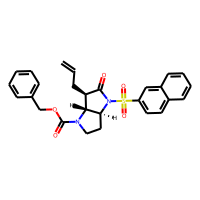
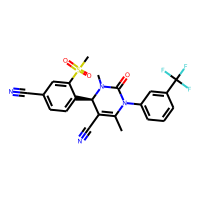
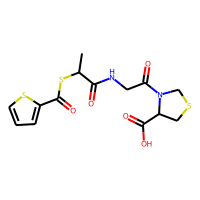
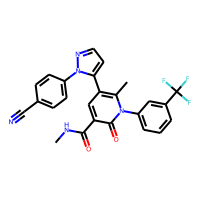
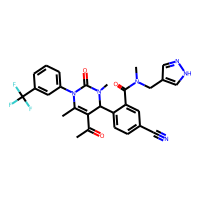

In [96]:
# same as above, just written in a nicer way
lip_prop = dict(MW = Descriptors.ExactMolWt, HBA = Descriptors.NumHAcceptors, HBD = Descriptors.NumHDonors, LP = Descriptors.MolLogP)
for lp in lip_prop:
    mol_data[lp] = [lip_prop[lp](mol) for mol in mol_data.ROMol] # here we store the values
mol_data.head()# dataframe with the calculated properties

array([[<AxesSubplot:title={'center':'MW'}>,
        <AxesSubplot:title={'center':'HBA'}>],
       [<AxesSubplot:title={'center':'HBD'}>,
        <AxesSubplot:title={'center':'LP'}>]], dtype=object)

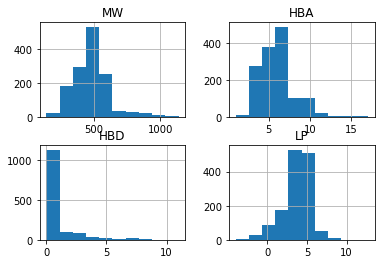

In [97]:
mol_data.hist(column = ['MW', 'HBA', 'HBD', 'LP']) # plot histograms

In [98]:
cutoff = 1. # as above, am arbitrary cutoff of 1nM to filter out the most active compounds
# let’s first filter out the compounds that satisfy the Lipinski’s rule of 5
lip = mol_data[(mol_data.MW<500) & (mol_data.HBA<10) & (mol_data.HBD<5) & (mol_data.LP<5)]
# and here we filter out the active compounds that satisfy the Lipinski’s rule of 5
active_lip = mol_data[(mol_data.IC50 < cutoff) & (mol_data.MW<500) & (mol_data.HBA<10) & (mol_data.HBD<5) & (mol_data.LP<5)]
print(len(mol_data), len(lip), len(active_lip))

1398 656 7


In [99]:
# importing some additional features needed to build a pharmacophore model
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
print(os.path.isfile(fdefName))
factory = Ph.ChemicalFeatures.BuildFeatureFactory(fdefName)   

True


In [100]:
AllChem.Compute2DCoords(m) # get 2D coordinates of a molecules (first molecules from the list)
feats = factory.GetFeaturesForMol(m) # calculates a set of features
# here we output the list of fetures calculated for this molecule
for f in feats:
    print(f.GetFamily(), f.GetType(), list(f.GetPos()))

Donor SingleAtomDonor [-2.3466742134712133, -0.07384027026736587, 0.0]
Acceptor SingleAtomAcceptor [2.002571667180477, 3.0821590921642237, 0.0]
Acceptor SingleAtomAcceptor [3.3233236881471035, 1.2836113176966915, 0.0]
Acceptor SingleAtomAcceptor [2.1519901081678072, -1.478268050489559, 0.0]
Acceptor SingleAtomAcceptor [-3.910881421326978, 2.0005887622358083, 0.0]
Acceptor SingleAtomAcceptor [-4.92528605789482, -0.39126893280160185, 0.0]
Aromatic Arom6 [5.499536266343706, -1.2686619463757312, 0.0]
Aromatic Arom6 [8.078148110767316, -0.951233283841499, 0.0]
Aromatic Arom6 [-8.701570062648914, -1.6117930478597164, 0.0]
Hydrophobe ThreeWayAttach [-0.47549705672355186, 2.0800567845504836, 0.0]
Hydrophobe ThreeWayAttach [4.118596582250581, -0.6829951563860821, 0.0]
Hydrophobe ThreeWayAttach [6.880475950436832, -1.8543287363653795, 0.0]
Hydrophobe ThreeWayAttach [6.697208426674191, -0.36556649385185136, 0.0]
Hydrophobe ThreeWayAttach [-7.50389790231843, -0.7086975953358363, 0.0]
Hydrophobe Ch

In [101]:
# we can do the same calculation, but now using the 3D representation of the same molecule
feats_3D = factory.GetFeaturesForMol(m_3D)
len(feats), len(feats_3D)# getting a bit more information using this approach

(19, 33)

In [102]:
# output a set of features calculated for the molecule based on its 3D representation
for f in feats_3D:
    print(f.GetFamily(), f.GetType(), list(f.GetPos()))

Donor SingleAtomDonor [1.0398749843499222, 0.25845396644149393, -1.0025258136891757]
Acceptor SingleAtomAcceptor [-0.6618312244911334, -3.5579566093407315, 1.4902957060568598]
Acceptor SingleAtomAcceptor [-3.5354357682685245, -2.773693322451415, -0.5040703545250584]
Acceptor SingleAtomAcceptor [-3.5166731672526237, -2.6906349695106098, 1.9439588449791987]
Acceptor SingleAtomAcceptor [2.789099983014197, 1.2851730113302122, -2.148403761644339]
Acceptor SingleAtomAcceptor [3.2628851169307453, -0.7582739197263214, -1.1850308731743462]
Aromatic Arom6 [-4.859286706927738, 0.7732703074162308, 0.6661700541401043]
Aromatic Arom6 [-6.3120240862579555, 2.354442584281633, -0.4761453286392836]
Aromatic Arom6 [6.0857430906974805, 1.0022591327511596, 0.29080590103363224]
Hydrophobe ThreeWayAttach [3.204313502217607, -4.141853972638165, 0.6124762711636759]
Hydrophobe ThreeWayAttach [2.472964547457459, -3.547802445414697, 1.5603760494986882]
Hydrophobe ThreeWayAttach [1.9920013495836886, -2.13018403545

In [103]:
#let’s get pharmacophore fingerprints of our molecule (combination of features and their distance)
# to do that, we need to prepare a list of some objects
sigFactory = SigFactory(factory,minPointCount=2,maxPointCount=3)
dist_bin = (0,2.5,5,8)
#dist_bin = (0,2,4,6,8)
dbins = []
for i in range(len(dist_bin)-1):
    dbins.append((dist_bin[i], dist_bin[i+1]))
print(dbins)
sigFactory.SetBins(dbins)
sigFactory.Init()
sigFactory.GetSigSize()

[(0, 2.5), (2.5, 5), (5, 8)]


3348

In [104]:
# now we generate a fingerprint of our molecule, based on its 2D structure
fp_m = Generate.Gen2DFingerprint(m,sigFactory)
# and its 3D structure
fp_m3D = Generate.Gen2DFingerprint(m_3D,sigFactory)
print(fp_m.GetNumOnBits(), fp_m3D.GetNumOnBits())

163 206


In [105]:
print(list(fp_m.GetOnBits())[:20])
print(list(fp_m3D.GetOnBits())[:20])
# expectedly, we get very similar fingerprints using 2D and 3D structures, but still different

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 28, 29, 30, 31, 32]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 28, 29, 30, 31, 32]


a fingerprint of a molecule is essentially a list of zeros and ones, where 1s represent that a given feature is present in a molecule, and 0s represent the absence of the respective feature

In [106]:
fp_m.ToBitString()# this is how it looks like

'111111111111111000000000000011111000000000000000111011000000000111111000000000000000000000000000000000000000000000000000100000000000110100110001000100010000000110100000001000000010000100100100110001000100011000110111100110001000100010000000110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000001010001001001001000000011001110001001001111001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010110011100011001001101010010010001000001001001001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111101000011111101000110001011001111001001001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

let’s build a pharmacophore hypothesis, based on 10 most active and 100 least active compounds
note that this is an arbitrary set. One could choose it differently

In [107]:
# fingerprints of 10 most active compounds
fp_a = []
for m in lip.ROMol[:10]:
    temp_fp = Generate.Gen2DFingerprint(m,sigFactory)
    fp_a.append(temp_fp)
# and fingerprints of 100 least active compounds (inactive)
fp_ina = []
for m in lip.ROMol[-100:]:
    temp_fp = Generate.Gen2DFingerprint(m,sigFactory)
    fp_ina.append(temp_fp)


In [108]:
# and now we extract most relevant features that differ between the two sets
# of active and inactive compounds
ranker = InfoBitRanker(len(fp_a[0]),2)
for fp in fp_a:
    ranker.AccumulateVotes(fp,1)
for fp in fp_ina:
    ranker.AccumulateVotes(fp,0)


In [109]:
# Let’s print the top 10 such features
top_f = ranker.GetTopN(10)
for fid,gain,n0,n1 in top_f:
    print(int(fid),'%.3f'%gain,int(n0),int(n1))

1311 0.151 10 8
2030 0.144 11 8
2144 0.131 4 6
1330 0.120 5 6
571 0.120 15 8
186 0.112 25 9
824 0.111 6 6
1338 0.111 6 6
361 0.110 17 8
1128 0.103 7 6


In [110]:
sigFactory.GetSigSize() # overall size of all features (combinations thereof) considered

3348

In [111]:
# feature 3 for instance is a combination of H-bond acceptor and aromatic ring
sigFactory.GetBitDescription(3)

'Acceptor Aromatic |0 0|0 0|'

To perform virtual screening using one of such proposed pharmacophore hypothesis, one could for instance
  - use the Tanimoto similarity to identify the positive hits (talktarial 4 from https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)
  - search for all compounds that satisfy all or most of the top N ranked features

## Project tasks
Start with a protein of choice (Exercise 1 and 2)
* extract ligands (Exercise 1 and 2)
* extract pharmacophore hypothesis
  - use 2D or 3D fingerprints as described here
  - or chemical similarity (talktarial 4 from https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)
  - or machine learning (talktarial 7 from https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)
  - or ligand-based approach (talktarial 9 from https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)
* perform the screening, i.e. apply the hypothesis on a set of compounds (Exercise 1 and 2)
* discuss results
  - is the applied approach able to identify active compounds and differentiate between active and inactive molecules. What are potential pitfalls of the approach and how could one address them.


In [112]:
# import needed libraries
import math
import pypdb
#import pymol

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections
import glob
import logging
import time

from tqdm import tqdm
import nglview

from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

%matplotlib inline
IPythonConsole.ipython_useSVG=True

In [113]:
# For talktorial 9

import os, glob

# RDKit
from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import ChemicalFeatures, rdDistGeom, Draw, rdMolTransforms, AllChem
from rdkit.Chem.Draw import IPythonConsole, DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
IPythonConsole.ipython_useSVG=True

import collections
import pandas as pd
import math

from sklearn import datasets, cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter # For handling the labels
import operator

## Start with extracting the ligands

So the second ID I used for my analysis was this one:

In [114]:
uniprot_id = "P08246" # Neutrophil elastase 
# https://www.uniprot.org/uniprot/P08246

### From exercise 1 I use the code we were given to search in the pdb database 

In [115]:
search_dict = pypdb.make_query(uniprot_id)
# now we submit the query
found_pdb_ids = pypdb.do_search(search_dict)
# here we look at how many hits we got
print(len(found_pdb_ids))

23


In [116]:
# here we look at the first 5 pdb codes
print(found_pdb_ids[:5])
# let's take a look at some information about the third structure
pdb_info = pypdb.describe_pdb('1BBZ')

for k in pdb_info:
    print(k,pdb_info[k])


['1B0F', '1H1B', '1HNE', '1PPF', '1PPG']
structureId 1BBZ
title CRYSTAL STRUCTURE OF THE ABL-SH3 DOMAIN COMPLEXED WITH A DESIGNED HIGH-AFFINITY PEPTIDE LIGAND: IMPLICATIONS FOR SH3-LIGAND INTERACTIONS
pubmedId 9698566
expMethod X-RAY DIFFRACTION
resolution 1.65
keywords COMPLEX (TRANSFERASE/PEPTIDE)
nr_entities 2
nr_residues 276
nr_atoms 2146
deposition_date 1998-04-28
release_date 1998-11-25
last_modification_date 2011-07-13
structure_authors Pisabarro, M.T., Serrano, L., Wilmanns, M.
citation_authors Pisabarro, M.T., Serrano, L., Wilmanns, M.
status CURRENT


In [117]:
# let’s collect data for all retrieved pdb codes
pdb_data = []
for pdb_id in found_pdb_ids:
    pdb_data.append(pypdb.describe_pdb(pdb_id))

# now we store this data in a pandas dataframe
pdbs = pd.DataFrame(pdb_data)
pdbs.head()# this function outputs first 5 lines of a dataframe

,structureId,title,pubmedId,expMethod,resolution,keywords,nr_entities,nr_residues,nr_atoms,deposition_date,release_date,last_modification_date,structure_authors,citation_authors,status,relatedPDB,pubmedCentralId
0,1B0F,CRYSTAL STRUCTURE OF HUMAN NEUTROPHIL ELASTASE...,9651152,X-RAY DIFFRACTION,3.00,HYDROLASE,1,218,1750,1998-11-09,1998-11-09,2020-07-29,"Schreuder, H.A., Metz, W.A., Peet, N.P., Pelto...","Cregge, R.J., Durham, S.L., Farr, R.A., Gallio...",CURRENT,NaN,NaN
1,1H1B,Crystal structure of human neutrophil elastase...,12190311,X-RAY DIFFRACTION,2.00,HYDROLASE,1,436,3426,2002-07-05,2002-08-29,2020-07-29,"Macdonald, S.J.F., Dowle, M.D., Harrison, L.A....","Macdonald, S.J.F., Dowle, M.D., Harrison, L.A....",CURRENT,"[{'@pdbId': '1B0F', '@details': 'CRYSTAL STRUC...",NaN
2,1HNE,Structure of human neutrophil elastase in comp...,2911584,X-RAY DIFFRACTION,1.84,HYDROLASE/HYDROLASE INHIBITOR,2,224,1667,1989-04-10,1989-10-15,2012-12-12,"Navia, M.A., Mckeever, B.M., Springer, J.P., L...","Navia, M.A., McKeever, B.M., Springer, J.P., L...",CURRENT,NaN,NaN
3,1PPF,X-RAY CRYSTAL STRUCTURE OF THE COMPLEX OF HUMA...,3640709,X-RAY DIFFRACTION,1.80,HYDROLASE/HYDROLASE INHIBITOR,2,274,2246,1991-10-24,1994-01-31,2020-07-29,"Bode, W., Wei, A-Z.","Bode, W., Wei, A.Z., Huber, R., Meyer, E., Tra...",CURRENT,NaN,NaN
4,1PPG,The refined 2.3 angstroms crystal structure of...,3391280,X-RAY DIFFRACTION,2.30,HYDROLASE/HYDROLASE INHIBITOR,2,224,1861,1991-10-24,1994-01-31,2020-07-29,"Bode, W., Wei, A-Z.","Wei, A.Z., Mayr, I., Bode, W.",CURRENT,NaN,NaN


In [118]:
ligand_dict = pypdb.get_ligands(found_pdb_ids[0]) # This gives the information about the ligand of the first pdb_id

In [119]:
ligand_dict

{'ligandInfo': {'ligand': {'@structureId': '1B0F',
   '@chemicalID': 'SEI',
   '@type': 'non-polymer',
   '@molecularWeight': '632.619',
   'chemicalName': '1-{3-METHYL-2-[4-(MORPHOLINE-4-CARBONYL)-BENZOYLAMINO]-BUTYRYL}-PYRROLIDINE-2-CARBOXYLIC ACID (3,3,4,4,4-PENTAFLUORO-1-ISOPROPYL-2-OXO-BUTYL)-AMIDE',
   'formula': 'C29 H37 F5 N4 O6',
   'InChIKey': 'XQAMVCHQGHAELT-FKBYEOEOSA-N',
   'InChI': 'InChI=1S/C29H37F5N4O6/c1-16(2)21(23(39)28(30,31)29(32,33)34)35-25(41)20-6-5-11-38(20)27(43)22(17(3)4)36-24(40)18-7-9-19(10-8-18)26(42)37-12-14-44-15-13-37/h7-10,16-17,20-22H,5-6,11-15H2,1-4H3,(H,35,41)(H,36,40)/t20-,21-,22-/m0/s1',
   'smiles': 'CC(C)[C@@H](C(=O)C(C(F)(F)F)(F)F)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C(C)C)NC(=O)c2ccc(cc2)C(=O)N3CCOCC3'}},
 'id': '1B0F'}

### Using Talktorial 8: 

 https://github.com/volkamerlab/teachopencadd/blob/master/talktorials/8_PDB/T8_PDB.ipynb

In [120]:
# first sort after resolution
pdbs_resolution = [float(i) for i in pdbs.resolution.tolist()]
pdbs = pdbs[[i <= 3.0 for i in pdbs_resolution]]  # keep only structures with resolution higher than 3 angström

pdbs = pdbs.sort_values(["resolution"], 
                        ascending=True, 
                        na_position='last')

In [121]:
pdbs.head()[["structureId", "resolution"]]

,structureId,resolution
18,5ABW,1.60
10,4WVP,1.63
6,2Z7F,1.70
12,5A0A,1.78
3,1PPF,1.80


3. Ligand-bound structures

Since we will create ensemble ligand-based pharmacophores in the next talktorial, we remove all PDB structures from our DataFrame, which do not contain a bound ligand: we use the pypdb function get_ligands to check/retrieve the ligand(s) from a PDB structure. PDB-annotated ligands can be ligands, cofactors, but also solvents and ions. In order to filter only ligand-bound structures, we (i) remove all structures without any annotated ligand and (ii) remove all structures that do not contain any ligands with a molecular weight (MW) greater than 100 Da (Dalton), since many solvents and ions weight less. Note: this is a simple, but not comprehensive exclusion of solvents and ions.


In [122]:
# Get all PDB IDs from DataFrame
pdb_ids = pdbs["structureId"].values.tolist()
pdb_ids

['5ABW',
 '4WVP',
 '2Z7F',
 '5A0A',
 '1PPF',
 '2RG3',
 '5A09',
 '1HNE',
 '4NZL',
 '3Q76',
 '5A8Y',
 '1H1B',
 '5A8Z',
 '3Q77',
 '5A0C',
 '5A0B',
 '5A8X',
 '1PPG',
 '6E69',
 '6SMA',
 '7CBK',
 '6F5M',
 '1B0F']

In [123]:
# Remove structures 
# (i) without ligand and 
# (ii) without any ligands with molecular weight (MW) greater than 100 Da (Dalton)

mw_cutoff = 100.0  # Molecular weight cutoff in Da

# This database query may take a moment
removed_pdb_ids = []
progressbar =  tqdm(pdb_ids, desc="Processing...")
for i in progressbar:
    # Try 5 times to avoid connection errors
    for retry in range(5):
        progressbar.set_description(f"Processing {i}...")
        try: 
            ligand_dict = pypdb.get_ligands(i)
            break
        except Exception as exc:
            time.sleep(0.5)
            continue
    else:  # if we didn't break (no success), then raise exception
        raise exc
            
    # (i) Remove structure if no ligand present
    if ligand_dict["ligandInfo"] is None:
        pdb_ids.remove(i) # Remove ligand-free PDB IDs from list
        removed_pdb_ids.append(i) # Store ligand-free PDB IDs

    # (ii) Remove structure if not a single annotated ligand has a MW above mw_cutoff
    else:
        # Get ligand information
        ligs = ligand_dict["ligandInfo"]["ligand"]
        # Technicality: if only one ligand, cast dict to list (for the subsequent list comprehension)
        if type(ligs) == dict:
            ligs = [ligs]
        # Get MW per annotated ligand
        mw_list = [float(i["@molecularWeight"]) for i in ligs]
        # Remove structure if not a single annotated ligand has a MW above mw_cutoff
        if sum([mw > mw_cutoff for mw in mw_list]) == 0:
            pdb_ids.remove(i) # Remove ligand-free PDB IDs from list
            removed_pdb_ids.append(i) # Store ligand-free PDB IDs

print("PDB structures without a ligand (removed from our data set):", *removed_pdb_ids)

Processing 1B0F...:  87%|████████▋ | 20/23 [00:04<00:00,  4.16it/s]

PDB structures without a ligand (removed from our data set): 2Z7F 1PPF 4NZL


In [124]:
print(f"Number of structures with ligand: {len(pdb_ids)}")

Number of structures with ligand: 20



#### Get meta information of ligands from top structures

In the next talktorial, we will build ligand-based ensemble pharmacophores from the top top_num structures with the highest resolution.


In [125]:
top_num = 4  # Number of top structures
pdb_ids = pdb_ids[0:top_num]
pdb_ids

['5ABW', '4WVP', '5A0A', '2RG3']

We fetch the PDB information about the top top_num ligands using get_ligands, to be stored as csv file (as dictionary per ligand).

If a structure contains several ligands, we select the largest ligand. Note: this is a simple, but not comprehensive method to select ligand binding the binding site of a protein. This approach may also select a cofactor bound to the protein. Therefore, please check the automatically selected top ligands visually before further usage.


In [126]:
ligands_list = []

for i in pdb_ids:
    # Try 5 times to avoid connection errors
    for retry in range(5):
        progressbar.set_description(f"Processing {i}...")
        try: 
            ligands = pypdb.get_ligands(i)["ligandInfo"]["ligand"]
            break
        except Exception as exc:
            time.sleep(0.5)
            continue
    else:  # if we didn't break (no success), then raise exception
        raise exc
    
    # Technicality: if only one ligand, cast dict to list (for the subsequent list comprehension)
    if isinstance(ligands, dict):
        ligands = [ligands]

    weight = 0
    this_lig = {}
    
    # If several ligands contained, take largest
    for lig in ligands:
        if float(lig["@molecularWeight"]) > weight:
            this_lig = lig
            weight = float(lig["@molecularWeight"])
            
    ligands_list.append(this_lig)

# Change the format to DataFrame
ligs = pd.DataFrame(ligands_list)
ligs

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChIKey,InChI,smiles
0,5ABW,WQQ,non-polymer,526.004,"1-(3-CHLOROPHENYL)-5-(3,5-DIMETHYLISOXAZOL-4-Y...",C26 H24 Cl N3 O5 S,QYWSDDYRNPGJNA-UHFFFAOYSA-N,InChI=1S/C26H24ClN3O5S/c1-15-24(17(3)35-29-15)...,Cc1c(c(on1)C)C2=C(N(C(=O)C(=C2)C(=O)NCc3ccc(cc...
1,4WVP,3V3,non-polymer,265.303,"1-amino-3,6,9,12-tetraoxapentadecan-15-oic acid",C11 H23 N O6,DKUZHSDZSMQOGQ-UHFFFAOYSA-N,InChI=1S/C11H23NO6/c12-2-4-16-6-8-18-10-9-17-7...,C(COCCOCCOCCOCCN)C(=O)O
2,5A0A,JJS,non-polymer,400.354,5-[(6R)-5-ethanoyl-4-methyl-2-oxidanylidene-3-...,C20 H15 F3 N4 O2,PGIVGIFOWOVINL-GOSISDBHSA-N,InChI=1S/C20H15F3N4O2/c1-11-17(12(2)28)18(13-6...,CC1=C([C@H](NC(=O)N1c2cccc(c2)C(F)(F)F)c3ccc(n...
3,2RG3,BG1,L-peptide linking,311.355,O-[(2S)-2-{methyl[(methylamino)sulfonyl]amino}...,C10 H21 N3 O6 S,ORANEODMBGJMSF-YUMQZZPRSA-N,"InChI=1S/C10H21N3O6S/c1-4-5-8(13(3)20(17,18)12...",CCC[C@@H](C(=O)OC[C@@H](C(=O)O)N)[N@](C)S(=O)(...


In [127]:
#import os
#os.chdir('/home/113600/structural_bioinformatics')
#os.getcwd()

In [128]:
ligs.to_csv("data/PDB_top_ligands.csv", header=True, index=False, sep="\t") 

#### Draw top ligand molecules

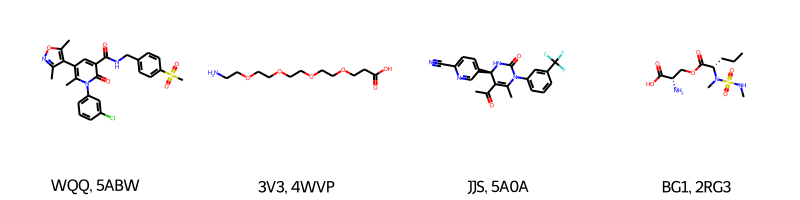

In [129]:
PandasTools.AddMoleculeColumnToFrame(ligs, "smiles")
Draw.MolsToGridImage(
    mols=list(ligs.ROMol), 
    legends=list(ligs["@chemicalID"]+', '+ligs["@structureId"]), 
    molsPerRow=top_num
)


#### Create protein-ligand ID pairs

In [130]:
pairs = collections.OrderedDict()

for idx, row in ligs.iterrows():
    pairs[str(row["@structureId"])] = str(row["@chemicalID"])

print(pairs)


OrderedDict([('5ABW', 'WQQ'), ('4WVP', '3V3'), ('5A0A', 'JJS'), ('2RG3', 'BG1')])


#### Align PDB structures

Since we want to build ligand-based ensemble pharmacophores in the next talktorial, it is necessary to align all structures to each other in 3D.

We will use one of our packages, opencadd, which includes a 3D superposition subpackage to guide the structural alignment of the proteins. The approach is based on superposition guided by sequence alignment provided matched residues. There are other methods in the package, but this simple one will be enough for the task at hand.



##### 1. Get the PDB structure files

We now fetch the PDB structure files, i.e. 3D coordinates of the protein, ligand (and if available other atomic or molecular entities such as cofactors, water molecules, and ions) from the PDB using opencadd.structure.superposition.

Available file formats are pdb and cif, which store the 3D coordinations of atoms of the protein (and ligand, cofactors, water molecules, and ions) as well as information on bonds between atoms. Here, we work with pdb files.


In [131]:
# Download PDB structures
from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
structures

[<Universe with 2067 atoms>,
 <Universe with 2051 atoms>,
 <Universe with 1905 atoms>,
 <Universe with 1823 atoms>]

##### 2. Extract protein and ligand

Extract protein and ligand from the structure in order to remove solvent and other artifacts of crystallography.


In [132]:
complexes = [Structure.from_atomgroup(structure.select_atoms(f"protein or resname {ligand}")) for structure, ligand in zip(structures, pairs.values())]
complexes

/apps/anaconda3/envs/opencadd/lib/python3.8/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sorted(unique_bonds)), 4)


[<Universe with 1663 atoms>,
 <Universe with 1664 atoms>,
 <Universe with 1646 atoms>,
 <Universe with 1649 atoms>]

In [133]:
# Write complex to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(f"data/{pdb_id}.pdb")

/apps/anaconda3/envs/opencadd/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/apps/anaconda3/envs/opencadd/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1026: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"



##### 3. Align proteins

Align complexes (based on protein atoms).


In [134]:
results = align(complexes, method=METHODS["mda"])

v = nglview.NGLWidget()
for complex_ in complexes:
    v.add_component(complex_.atoms)
v

NGLWidget()

In [135]:
v

NGLWidget()

In [136]:
v.render_image();

In [137]:
v._display_image()

##### _4. Extract ligands_

In [138]:
ligands = [Structure.from_atomgroup(complex.select_atoms(f"resname {ligand}")) for complex, ligand in zip(complexes, pairs.values())]
ligands

/apps/anaconda3/envs/opencadd/lib/python3.8/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sorted(unique_bonds)), 4)


[<Universe with 36 atoms>,
 <Universe with 17 atoms>,
 <Universe with 29 atoms>,
 <Universe with 19 atoms>]

In [139]:
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(f"data/{pdb_id}_lig.pdb")

/apps/anaconda3/envs/opencadd/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/apps/anaconda3/envs/opencadd/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1026: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"


In [140]:
mol_files = []
for file in glob.glob("data/*_lig.pdb"):
    mol_files.append(file)
mol_files

['data/5ABW_lig.pdb',
 'data/4WVP_lig.pdb',
 'data/5A0A_lig.pdb',
 'data/2RG3_lig.pdb']

In [141]:
v = nglview.NGLWidget()

ligand_colors = {0: 'magenta', 1: 'cyan', 2: 'yellow', 3: 'grey'}

for component_id, ligand in enumerate(ligands):
    v.add_component(ligand.atoms)
    v.remove_ball_and_stick(component=component_id)
    v.add_licorice(component=component_id, colorScheme="element", colorValue=ligand_colors[component_id])
v

NGLWidget()

In [142]:
v.render_image();

In [143]:
v._display_image()

## Extract pharmacophore hypothesis

### Ligand-based approach (talktorial 9)

In [144]:
mol_files = list(glob.glob("data/*_lig.pdb"))
mol_files

['data/5ABW_lig.pdb',
 'data/4WVP_lig.pdb',
 'data/5A0A_lig.pdb',
 'data/2RG3_lig.pdb']

In [145]:
pdb_ids = [os.path.basename(i).split("_")[0] for i in mol_files]
pdb_ids

['5ABW', '4WVP', '5A0A', '2RG3']

In [146]:
# read all ligands from these PDB files using RDKit
mols = []
for mol_file in mol_files:
    mol = Chem.MolFromPDBFile(mol_file, removeHs=False)
    if mol is None:
        print(mol_file, 'could not be read')
    else:
        Chem.SanitizeMol(mol)
        print(Chem.MolToSmiles(mol))
        mols.append(mol)
rangeMols = range(1, len(mols)+1)
print('Number of molecules: ', len(mols))

CC1NOC(C)C1C1CC(C(O)NCC2CCC(S(C)(O)O)CC2)C(O)N(C2CCCC(Cl)C2)C1C
NCCOCCOCCOCCOCCCO
CC(O)C1C(C2CCC(CN)NC2)NC(O)N(C2CCCC(C(F)(F)F)C2)C1C
CCCC(C(O)OCC(N)CO)N(C)S(O)(O)NC
Number of molecules:  4


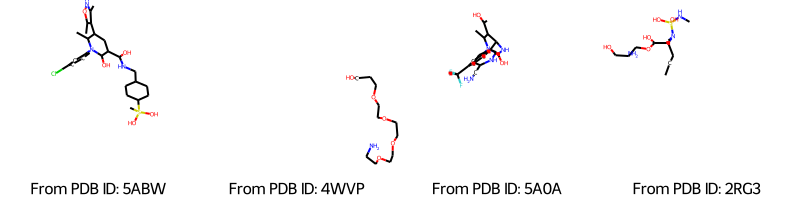

In [147]:
Draw.MolsToGridImage(mols, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

In [148]:
# Load SMILES for PDB ligand structures
ligs = pd.read_csv("data/PDB_top_ligands.csv", sep="\t")

# Get SMILES in the same order as in pdb_ids
ligs_smiles = [ligs[ligs["@structureId"]==pdb_id]["smiles"].values[0] for pdb_id in pdb_ids]

# Generate RDKit Mol object from SMILES
refmols = [Chem.MolFromSmiles(smiles) for smiles in ligs_smiles]

# Assign bond orders to molecules (mols) based on SMILES patterns (refmols)
#mols = [AllChem.AssignBondOrdersFromTemplate(refmol, mol) for refmol, mol in zip(refmols, mols)]

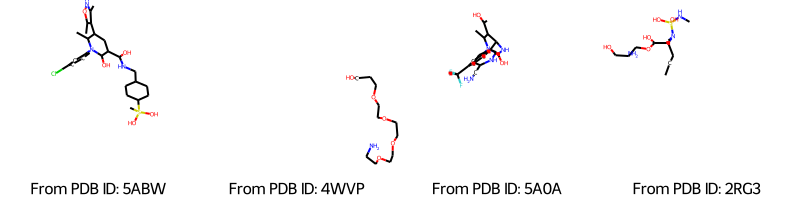

In [149]:
Draw.MolsToGridImage(mols, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

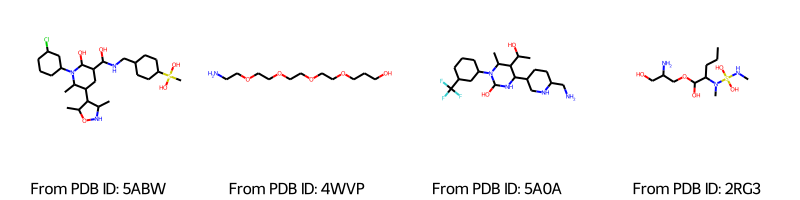

In [150]:
mols_2D = [] 
for mol in mols:
    tmp=Chem.Mol(mol)
    AllChem.Compute2DCoords(tmp)
    mols_2D.append(tmp)
Draw.MolsToGridImage(mols_2D, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

#### Visualize with nglview

In [151]:
import nglview as nv

In [152]:
import time
def show_ligands(rdkit_mols):
    v = nv.NGLWidget()
    for mol in rdkit_mols:
        c = v.add_component(Chem.MolToPDBBlock(mol), ext="pdb")
        time.sleep(0.1)
        c.clear()
        c.add_ball_and_stick(multipleBond=True)
    return v

In [153]:
v = show_ligands(mols)

In [154]:
v.render_image(),

(Image(value=b'', width='99%'),)

In [155]:
v._display_image()

#### Extract pharmacophore features

In [156]:
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))

In [157]:
list(ffact.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

In [158]:
# example
m1 = mols[0]
feats = ffact.GetFeaturesForMol(m1)
print('Number of features found:',len(feats))

Number of features found: 21


In [159]:
feats[0].GetFamily() # type of a feature

'Donor'

In [160]:
# frequency of feature types in the molecule
feats_freq = collections.Counter([x.GetFamily() for x in feats])
feats_freq

Counter({'Donor': 7,
         'Acceptor': 5,
         'PosIonizable': 2,
         'Hydrophobe': 6,
         'LumpedHydrophobe': 1})

In [161]:
# Get feature type frequency per molecule
mols_feats_freq = []
for i in mols:
    feats = [x.GetFamily() for x in ffact.GetFeaturesForMol(i)]
    feats_freq = collections.Counter(feats)
    mols_feats_freq.append(feats_freq)

# Show data as DataFrame
p = pd.DataFrame(mols_feats_freq, index=["m"+str(i) for i in range(1, len(mols)+1)]).fillna(0).astype(int)
p.transpose()

,m1,m2,m3,m4
Donor,7,2,6,6
Acceptor,5,5,2,5
PosIonizable,2,1,4,1
Hydrophobe,6,1,3,2
LumpedHydrophobe,1,0,0,0


In [162]:
acceptors = []
donors = []
hydrophobics = []

for i in mols:
    acceptors.append(ffact.GetFeaturesForMol(i, includeOnly='Acceptor'))
    donors.append(ffact.GetFeaturesForMol(i, includeOnly='Donor'))
    hydrophobics.append(ffact.GetFeaturesForMol(i, includeOnly='Hydrophobe'))
    
features = {"donors": donors,
            "acceptors": acceptors,
            "hydrophobics": hydrophobics}

#### Show the pharmacophore features of all ligands

In [163]:
feature_colors = {"donors": (0,0.9,0),  # Green
                  "acceptors": (0.9,0,0),  # Red 
                  "hydrophobics": (1,0.9,0)}  # Yellow

In [164]:
def visualize_features(molecules, feature_type, features, color="yellow", sphere_radius=0.5):
    print("Number of", feature_type, "in all ligands:", sum([len(i) for i in features]))
    v = show_ligands(molecules)
    for i, feature in enumerate(features, 1):
        for feat in feature:
            loc = list(feat.GetPos())
            label = f"{feature_type}_{i}"
            v.shape.add_sphere(loc, color, sphere_radius, label)
    return v

In [165]:
# Hydrogen bond donors
feature_type = "donors"
v = visualize_features(mols, feature_type, features[feature_type], feature_colors[feature_type])
v

Number of donors in all ligands: 21


NGLWidget()

In [84]:
v.render_image(),

(Image(value=b'', width='99%'),)

In [85]:
v._display_image()

In [166]:
# Hydrogen bond acceptors
feature_type = "acceptors"
v = visualize_features(mols, feature_type, features[feature_type], feature_colors[feature_type])
v

Number of acceptors in all ligands: 17


NGLWidget()

In [87]:
v.render_image(),

(Image(value=b'', width='99%'),)

In [88]:
v._display_image()

In [167]:
# Hyrophobic contacts
feature_type = "hydrophobics"
v = visualize_features(mols, feature_type, features[feature_type], feature_colors[feature_type])
v

Number of hydrophobics in all ligands: 12


NGLWidget()

In [90]:
v.render_image(),

(Image(value=b'', width='99%'),)

In [91]:
v._display_image()

#### Collect coordinates of features per feature type

In [168]:
features_coord = {"donors": [list(item.GetPos()) for sublist in features["donors"] for item in sublist],
                  "acceptors": [list(item.GetPos()) for sublist in features["acceptors"] for item in sublist],
                  "hydrophobics": [list(item.GetPos()) for sublist in features["hydrophobics"] for item in sublist]}

In [169]:
features_coord["acceptors"]

[[27.805, -18.851, 5.953],
 [29.987, -24.84, 1.657],
 [32.311, -23.449, 4.857],
 [35.303, -30.305, 7.995],
 [33.303, -31.287, 6.967],
 [38.317, -35.171, 5.355],
 [39.848, -33.532, 3.839],
 [38.9, -30.78, 3.13],
 [37.702, -28.4, 2.208],
 [35.291, -26.222, 1.738],
 [29.742, -24.604, 1.841],
 [27.132, -19.248, 3.635],
 [23.775, -23.053, 1.24],
 [19.414, -22.824, 0.525],
 [23.836, -21.745, -0.532],
 [26.439, -19.746, -0.054],
 [24.919, -19.774, 1.783]]

#### Generate ensemble pharmacophores

In [94]:
# set static parameters for kmeans clustering
# k quotient (kq) used to determine k in k-means: k = number of feature points / kq
# kq should be selected so that k (feature clusters) is for all clusters at least 1 and not larger than 4-5 clusters
kq = 7

In [95]:
# Threshold for clustering: number = percentage of threshold value
min_cluster_size = int(len(mols) * 0.75)

# Show only top features
top_cluster_number = 4

In [96]:
# Define k-means clustering and cluster selection functions 
def clustering(feature_coord, kd):
    '''
    This functions computes the k-means clustering of input feature coordinates.
    '''
    
    # Define parameter k as feature number divided by "k quotient"
    k = math.ceil(len(feature_coord) / kq)
    k = 2 if k == 1 else k  # Tailor-made adaption of k for hydrophobics in for the example in this talktorial
    print('Clustering: \nVariable k in k-means: %d of %d points\n'%(k, len(feature_coord)))
    
    # Initialize of k-means
    k_means = cluster.KMeans(n_clusters=k)
    
    # Compute the k-means clustering
    k_means.fit(feature_coord)
    
    # Return the clusters
    return k_means

In [97]:
def get_clusters(k_means, min_cluster_size, top_cluster_number):
    '''
    This function retrieves information on a input k-means clustering:
    * gets cluster label for each feature
    * counts cluster sizes and sort cluster indices by cluster size
    * selects clusters based on size
    * returns selected cluster indices
    '''
    
    # Sort clusters by size and only show largest
    feature_labels = k_means.labels_
    print('Cluster labels for all features: \n%s\n'% feature_labels)

    feature_labels_count = Counter(feature_labels)
    print('Cluster label counter: \n%s\n'% feature_labels_count)

    feature_labels_count = sorted(feature_labels_count.items(), 
                                  key=operator.itemgetter(1), 
                                  reverse=True)
    print('Sorted cluster label counters: \n%s\n'% feature_labels_count)

    # Get number of the largest clusters, which are larger then the threshold (selected clusters)
    cluster_indices_sel = []
    
    for cluster_index, cluster_size in feature_labels_count:  # feature_labels_count = list of (cluster_index, cluster_size)
        if cluster_size >= min_cluster_size and top_cluster_number > 0:
            cluster_indices_sel.append(cluster_index)
            top_cluster_number -= 1
            
    print('Cluster indices of selected clusters: \n%s\n'% cluster_indices_sel)
    
    return cluster_indices_sel

In [98]:
# Cluster features
k_means = {"donors": clustering(features_coord["donors"], kq), 
           "acceptors": clustering(features_coord["acceptors"], kq),
           "hydrophobics": clustering(features_coord["hydrophobics"], kq)}

Clustering: 
Variable k in k-means: 3 of 21 points

Clustering: 
Variable k in k-means: 3 of 17 points

Clustering: 
Variable k in k-means: 2 of 12 points



In [99]:
# Select relevant clusters
print("Hydrogen bond donors\n")
cluster_indices_sel_don = get_clusters(k_means["donors"], min_cluster_size, top_cluster_number)
print("Hydrogen bond acceptors\n")
cluster_indices_sel_acc = get_clusters(k_means["acceptors"], min_cluster_size, top_cluster_number)
print("Hydrophobic contacts\n")
cluster_indices_sel_h = get_clusters(k_means["hydrophobics"], min_cluster_size, top_cluster_number)

Hydrogen bond donors

Cluster labels for all features: 
[2 0 0 0 0 1 1 1 0 0 0 2 0 0 0 2 2 2 2 2 2]

Cluster label counter: 
Counter({0: 10, 2: 8, 1: 3})

Sorted cluster label counters: 
[(0, 10), (2, 8), (1, 3)]

Cluster indices of selected clusters: 
[0, 2, 1]

Hydrogen bond acceptors

Cluster labels for all features: 
[1 0 0 2 2 2 2 2 2 0 0 1 1 1 1 1 1]

Cluster label counter: 
Counter({1: 7, 2: 6, 0: 4})

Sorted cluster label counters: 
[(1, 7), (2, 6), (0, 4)]

Cluster indices of selected clusters: 
[1, 2, 0]

Hydrophobic contacts

Cluster labels for all features: 
[0 0 0 0 1 1 1 0 0 0 0 0]

Cluster label counter: 
Counter({0: 9, 1: 3})

Sorted cluster label counters: 
[(0, 9), (1, 3)]

Cluster indices of selected clusters: 
[0, 1]



In [100]:
cluster_indices_sel = {"donors": cluster_indices_sel_don, 
                       "acceptors": cluster_indices_sel_acc, 
                       "hydrophobics": cluster_indices_sel_h}

In [101]:
# get cluster coordinates
def get_selected_cluster_center_coords(k_means, cluster_indices_sel, feature_type):
    '''
    This function retrieves cluster center coordinates for selected clusters (by their indices).
    '''
    
    # Get cluster centers for a certain feature type
    cluster_centers = k_means[feature_type].cluster_centers_
    
    # Cast to list and then to pandas Series (for element selection by indices)
    cluster_centers = pd.Series(cluster_centers.tolist())
    
    # Select cluster centers by indices of selected clusters
    cluster_centers_sel = cluster_centers[cluster_indices_sel[feature_type]]
    
    # Cast to list and return
    return list(cluster_centers_sel)

In [102]:
cluster_centers_sel = {"donors": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "donors"),
                       "acceptors": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "acceptors"),
                       "hydrophobics": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "hydrophobics")}
cluster_centers_sel["acceptors"]

[[24.76, -20.748714285714286, 1.7928571428571427],
 [37.228833333333334, -31.579166666666666, 4.915666666666667],
 [31.832749999999997, -24.778750000000002, 2.52325]]

#### Show clusters

In [103]:
def visualize_clusters(molecules, feature_type, features, clusters, 
                       color="yellow", feature_radius=0.5, cluster_radius=1):
    v = visualize_features(molecules, feature_type, features, color=color, sphere_radius=feature_radius)
    for i, center in enumerate(clusters, 1):
        v.shape.add_sphere(list(center), color, cluster_radius, f"cluster_{feature_type}_{i}")
    return v

In [104]:
# Hydrogen bond donors
feature_type = "donors"
v = visualize_clusters(mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type], 
                   feature_colors[feature_type])
v

Number of donors in all ligands: 21


NGLWidget()

In [105]:
v.render_image(),

(Image(value=b'', width='99%'),)

In [106]:
v._display_image()

In [107]:
# Hydrogen bond acceptor
feature_type = "acceptors"
v = visualize_clusters(mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type],  
                   feature_colors[feature_type])
v

Number of acceptors in all ligands: 17


NGLWidget()

In [108]:
v.render_image(),

(Image(value=b'', width='99%'),)

In [109]:
v._display_image()

In [110]:
# Hydrophobic contacts
feature_type = "hydrophobics"
v = visualize_clusters(mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type], 
                   feature_colors[feature_type])
v

Number of hydrophobics in all ligands: 12


NGLWidget()

In [111]:
v.render_image(),

(Image(value=b'', width='99%'),)

In [112]:
v._display_image()

#### Show ensemble pharmacophore

In [113]:
v = show_ligands(mols)
# Load clusters
for feature_type in cluster_indices_sel.keys():
    centers = cluster_centers_sel[feature_type]
    for i, loc in enumerate(centers):
        sphere_radius = 1
        feature_color = feature_colors[feature_type]
        label = f"{feature_type}_c{i}"
        v.shape.add_sphere(loc, feature_color, sphere_radius, label)
v

NGLWidget()

In [114]:
v.render_image(),

(Image(value=b'', width='99%'),)

In [115]:
v._display_image()

## perform the screening, i.e. apply the hypothesis on a set of compounds (Exercise 1 and 2)

I still don't get how this works now, I know that I found some properties of the ligands and that I need to search for these properties in the compounds to find possible ideas for a new drug.

I also did use talktorial 4 to use what I got also on the compounds but I do not see how this now combines my results from talktorial 9.

So I changed everywhere the data to my protein (also in your code used here above) but still I don't think that I got that right.

### According to talktorial 4 I decided to use the first of the extracted ligands to search in the compounds: 
It is Neutrophil elastase inhibitors for the treatment of (cardio)pulmonary diseases

In [69]:
query_comp = 'CC1NOC(C)C1C1CC(C(O)NCC2CCC(S(C)(O)O)CC2)C(O)N(C2CCCC(Cl)C2)C1C'

In [73]:
# Import relevant Python packages
# The majority of the basic molecular functionality is found in module rdkit.Chem
from rdkit import Chem
# Drawing related
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs

import math
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt

In [74]:
# Import data from csv file containing compounds in SMILES format
filtered_df = pd.read_csv('data/EGFR_compounds_lipinski.csv', delimiter=';', usecols=['molecule_chembl_id', 'smiles', 'pIC50'])
filtered_df.head() 

,molecule_chembl_id,smiles,pIC50
0,CHEMBL2367667,C=CC[C@H]1C(=O)N(S(=O)(=O)c2ccc3ccccc3c2)[C@H]...,10.443697
1,CHEMBL3617973,CC1=C(C#N)[C@@H](c2ccc(C#N)cc2S(C)(=O)=O)N(C)C...,10.187087
2,CHEMBL293138,CC(SC(=O)c1cccs1)C(=O)NCC(=O)N1CSCC1C(=O)O,10.000000
3,CHEMBL3617966,CNC(=O)c1cc(-c2ccnn2-c2ccc(C#N)cc2)c(C)n(-c2cc...,9.677781
4,CHEMBL4110495,[C-]#[N+]C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N[C@...,9.522879


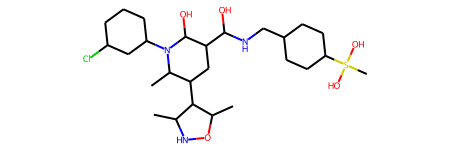

In [75]:
# Generate Mol object from SMILES of query compound
query = Chem.MolFromSmiles(query_comp); 
query

In [76]:
# Generate MACCS and Morgan fingerprints for query compound
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circ_fp_query = rdFingerprintGenerator.GetCountFPs([query])[0]

In [77]:
# Generate MACCS and Morgan fingerprints for all molecules in file
ms = [Chem.MolFromSmiles(i) for i in filtered_df.smiles]
circ_fp_list = rdFingerprintGenerator.GetCountFPs(ms)
maccs_fp_list = [MACCSkeys.GenMACCSKeys(m) for m in ms]

In [78]:
# Calculate Tanimoto similarity for query compound and all molecules in file (MACCS, Morgan)
tanimoto_maccs = DataStructs.BulkTanimotoSimilarity(maccs_fp_query,maccs_fp_list)
tanimoto_circ = DataStructs.BulkTanimotoSimilarity(circ_fp_query,circ_fp_list)

In [79]:
# Calculate Dice similarity for query compound and all molecules in file (MACCS, Morgan)
dice_maccs = DataStructs.BulkDiceSimilarity(maccs_fp_query,maccs_fp_list)
dice_circ = DataStructs.BulkDiceSimilarity(circ_fp_query,circ_fp_list)

In [80]:
# Make table with ChEMLB ID, SMILES and Tanimoto similarity of the compounds to Gefitinib
similarity_df = pd.DataFrame({'ChEMBL_ID':filtered_df.molecule_chembl_id,
                              'bioactivity':filtered_df.pIC50,
                              'tanimoto_MACCS': tanimoto_maccs, 
                              'tanimoto_morgan': tanimoto_circ, 
                              'dice_MACCS': dice_maccs,
                              'dice_morgan': dice_circ,
                              'smiles': filtered_df.smiles,})

In [81]:
# Show DataFrame
similarity_df.head()

,ChEMBL_ID,bioactivity,tanimoto_MACCS,tanimoto_morgan,dice_MACCS,dice_morgan,smiles
0,CHEMBL2367667,10.443697,0.510204,0.064171,0.675676,0.120603,C=CC[C@H]1C(=O)N(S(=O)(=O)c2ccc3ccccc3c2)[C@H]...
1,CHEMBL3617973,10.187087,0.458333,0.038889,0.628571,0.074866,CC1=C(C#N)[C@@H](c2ccc(C#N)cc2S(C)(=O)=O)N(C)C...
2,CHEMBL293138,10.000000,0.433333,0.085526,0.604651,0.157576,CC(SC(=O)c1cccs1)C(=O)NCC(=O)N1CSCC1C(=O)O
3,CHEMBL3617966,9.677781,0.433333,0.048128,0.604651,0.091837,CNC(=O)c1cc(-c2ccnn2-c2ccc(C#N)cc2)c(C)n(-c2cc...
4,CHEMBL4110495,9.522879,0.436170,0.039773,0.607407,0.076503,[C-]#[N+]C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N[C@...


So I know that this is just a "random" ligand from the list of extracted ligands I used now for the search but I did not find out how to get the smiles code that is then used for the screening, after the extraction of the pharmacophore features but I am sure we will solve that next week.